### Dive into the Boston and Seattle Airbnb dataset

#### CRISP-DM Process

**Business Understanding**: Here, we try to understand what's the driving factors that determine the Airbnb rental price for Boston and Seattle housing. In this project, we mainly would like to understand the following three quesitons. 

1. Is there significant price difference in Airbnb housting between Boston and Seattle ?
2. What's the major driving factors to predict airbnb housing price for Boston and Seattle respectively ?
3. What are the top factors that people needs to most when they consider Airbnb housing? 

**Data Understanding**：Datasets from both Boston and Seattle are investigated before data processing   
**Prepare Data**: Data cleanning, Processing NaN inputs  
**Data Modeling**: Train the model and find the corresponding parameters to predict housing price  
**Model Validation** Test the model and evaluate the effectiveness of the model


In [262]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LogisticRegression
import sklearn.metrics
from sklearn.model_selection import GridSearchCV

%matplotlib inline 

listings_Boston = pd.read_csv("boston_listings.csv")
listings_Seattle = pd.read_csv("seattle_listings.csv")



#listings_Boston.columns[~listings_Boston.columns.isin(listings_Seattle)]


In [263]:
def data_cleanup(listings):
    '''
    input:
        listings: The listings dataset of target city.
    output:
        df2: Cleanup data used for price predition
        price: price of the properties.
    '''
    
    #drop some irrevleent 
    listings.drop(['listing_url', 'scrape_id','last_scraped', 'name', 'summary', 'space',
                         'description','neighborhood_overview', 'notes','transit', 'access', 'interaction','house_rules',
                         'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url','host_name','host_location', 'host_about',
                          'host_thumbnail_url', 'host_picture_url','city', 'state', 'smart_location', 'smart_location', 'country_code', 'country', 'first_review', 'last_review', 'id', 'host_verifications', 
                   'host_id', 'neighbourhood', 'calendar_last_scraped', 'market','street', 'host_since'], axis = 1, inplace = True)


    # Dropping NaN with ratio more than 75%
    dropping_index = listings.isnull().sum() / listings.shape[0] > 0.75
    listings.drop(listings.columns[dropping_index], axis = 1, inplace = True)


    #takes care some data type issues
    listings['host_response_rate'] = listings['host_response_rate'].replace('%','', regex = True).astype(float)
    listings['host_acceptance_rate'] = listings['host_acceptance_rate'].replace('%','', regex = True).astype(float)
    listings['cleaning_fee'] = listings['cleaning_fee'].replace('\$', '',regex = True).astype(float)
    listings['price'] = listings['price'].replace({'\$': '', ',':''}, regex = True).astype(float)
    listings['extra_people'] = listings['extra_people'].replace({'\$': '', ',':''}, regex = True).astype(float)
    listings['security_deposit'] = listings['security_deposit'].replace({'\$': '', ',':''}, regex = True).astype(float)

    if type(listings.zipcode[0]) == str:
            listings.zipcode = listings.zipcode.str[:5].apply(lambda x: float(x))

    listings['amenities'] = listings['amenities'].map(lambda d: [amenity.replace('"', "").replace("{", "").replace("}", "") for amenity in d.split(",")])


    possible_amenities = set([item for sublist in listings['amenities'] for item in sublist])
    possible_amenities = list(possible_amenities)


    mlb = MultiLabelBinarizer()
    amenities_result = pd.DataFrame(mlb.fit_transform(listings['amenities']), columns = mlb.classes_, index = listings_Boston.index)
    listings = pd.concat([listings.drop(['amenities'], axis = 1), amenities_result], axis = 1, sort = False)


    cat_column = listings.select_dtypes(include = 'object').columns


    for col in cat_column:
        dummy_column = pd.get_dummies(listings[col], prefix = col )
        listings = pd.concat([listings.drop([col], axis = 1), dummy_column], axis = 1)


    numeric_column = listings.select_dtypes(include = ['float', 'int']).columns

    #listings_Boston['host_response_rate'].fillna(value = listings_Boston['host_response_rate'].mean())
    for col in numeric_column:
        listings[col].fillna(value = listings[col].mean(), inplace = True)

    y = listings['price']
    X = listings.drop(['price'], axis = 1)
    return y, X

    

In [282]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

r2_score(y_test, y_test_preds)

    # Grid Search to find Best Parameter
param_grid = {'n_estimators': [400], 'learning_rate': [0.05],'max_depth': [10],'min_samples_split': [5],'subsample': [0.7]}

forest_reg = GradientBoostingRegressor(random_state = 42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring = 'neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
#cvres = grid_search.cv_results_
#for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#    print(np.sqrt(-mean_score), params)
y_pred = grid_search.predict(X_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'learning_rate': 0.05, 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 400, 'subsample': 0.7}


In [285]:
print("Error Score on Test Data: {}.".format(np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred))))

Error Score on Test Data: 133.92980093442586.


In [292]:
feature_importances = grid_search.best_estimator_.feature_importances_
listings_Boston.columns.tolist()

['host_response_rate',
 'host_acceptance_rate',
 'host_listings_count',
 'host_total_listings_count',
 'zipcode',
 'latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'price',
 'security_deposit',
 'cleaning_fee',
 'guests_included',
 'extra_people',
 'minimum_nights',
 'maximum_nights',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'calculated_host_listings_count',
 'reviews_per_month',
 '',
 '24-Hour Check-in',
 'Air Conditioning',
 'Breakfast',
 'Buzzer/Wireless Intercom',
 'Cable TV',
 'Carbon Monoxide Detector',
 'Cat(s)',
 'Dog(s)',
 'Doorman',
 'Dryer',
 'Elevator in Building',
 'Essentials',
 'Family/Kid Friendly',
 'Fire Extinguisher',
 'First Aid Kit',
 'Free Parking on Premises',
 'Free Parking on Stree

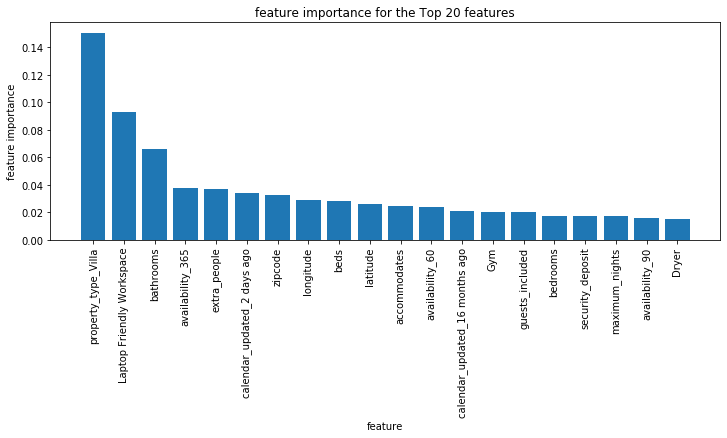

In [290]:
feature_importances
features = sorted(zip(feature_importances, listings_Boston.columns), reverse=True)
attribute = []
coefficient = []
for feature in features:
    attribute.append(feature[1]) 
    coefficient.append(feature[0])
plt.figure(figsize=(12,4))
plt.bar(attribute[:20], height=coefficient[:20])
plt.xticks(rotation=90)
plt.xlabel('feature')
plt.ylabel('feature importance')
plt.title('feature importance for the Top 20 features')
plt.show()